In [11]:
!pip install num2words
!pip install contractions
!pip install pyspellchecker

In [12]:
import numpy as np
import nltk
import sklearn
import pandas as pd
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
import re,string
# download and loade the stop words from nltk library
nltk.download('stopwords') 
stopwords=set(nltk.corpus.stopwords.words('english'))
stopwords.add("'s")
nltk.download('punkt') 
nltk.download('wordnet') 
nltk.download('averaged_perceptron_tagger')
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import wordnet
import operator
from num2words import num2words
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
%matplotlib inline
import contractions
from spellchecker import SpellChecker
spell = SpellChecker()


import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,SimpleRNN,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from collections import Counter





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
abbreviation = {
'TMR': 'TOMORROW',
'BOUT':'ABOUT' ,
'PLZ': 'PLEASE',
'B4': 'BEFORE',
"AFAIK":"As Far As I Know",
"ASAP":"As Soon As Possible",
"B4N":"Bye For Now",
"BRB":"Be Right Back",
"BTW":"By The Way",
"B4":"Before",
"GG":"Good Game",
"GN":"Good Night",
"GR8":"Great",
"IC":"I See",
"LTNS":"Long Time No See",
"PRT":"Party",
"THX":"Thank You",
"U2":"You Too",
"WTF":"What The FUCK",
"OMG":"OH MY GOD",
"BAMF":"BADASS MOTHER FUCKER",
"GTFO": "GET THE FUCK OUT",
"STFU": "SHUT THE FUCK UP",
"U":"YOU"

};


In [14]:
def create_csv(text_file,label_file,output_file):
  print("Creating ",output_file,"From",text_file,label_file)
  dataset_text_file = open(text_file).readlines()

  dataset_label_file = open(label_file).readlines()

  data=[] 
  labels=[] 

  for line in dataset_text_file:
    data.append(line)
  for label in dataset_label_file:
    labels.append(label)

  datadict = {'text':data, 'label':labels}

  df = pd.DataFrame(datadict)
  df.to_csv(output_file)
  print("............ Done")

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

In [16]:
# remove duplicates
def remove_duplicates(df):
  df = df.drop_duplicates(keep="first")
  return df

# deal with missing value  
def deal_with_missing_value(df):
  df = df.drop(df[df['text'].map(len) <= 0].index)
  return df

# tag POS for the wordnet lemmatizer
def nltk_pos_tagger(nltk_tag):

    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def remove_url(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')    
    return text

def remove_mention_hashtag(text):
    prefixes = ['@',"#"]
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in prefixes:
                words.append(word)
    return ' '.join(words)

def replacing_abbreviation_and_slang(text,abbreviation):
  rm =" "
  for word in text.split():
      word = word.upper()
      if word in abbreviation:
         word = word.replace(word, abbreviation[word])
      rm += word+" "

  return rm


def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)



def preprocess(text):
    if type(text) is not int:
        # remove emojis
        text = remove_emojis(text)
        # remove url
        text = remove_url(text)
        # remove mention hashtag
        text = remove_mention_hashtag(text)
        # Expand  contractions
        text = contractions.fix(text)
        # replacing abbreviation and slang
        text = replacing_abbreviation_and_slang(text,abbreviation)
        
        # Replace every special char with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # Remove Apostrophe with space
        text = re.sub("'", ' ', text)

        #Spelling correction
        tex=""
        for word in text.split():
              tex += spell.correction(word) + " "

        string = ""      
        # Convert number to word
        for word in tex.split():
            if word.isdigit():
                string += num2words(word) + " "
            else: string += word+ " "
        # Replace every special char with space after Convert num 2 word
        string = re.sub('[^a-zA-Z0-9\n]', ' ', string)
        # Replace singil char with space
        string = re.sub('(?:^| )\w(?:$| )', ' ', string).strip()
        # Replace multiple spaces with single_space
        string = re.sub('\s+',' ', string)
        # Converting all the chars into lower case
        string = string.lower()
        # lemmatizer with POS tag
        lemmatizerstring=" "
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(string))  
        wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
          if tag is None:
            lemmatizerstring+=word+ " "
          else:        
            lemmatizerstring+=lemmatizer.lemmatize(word, tag)+ " "
           
        # Remove Stop Words
        rm=""
        for word in lemmatizerstring.split():
            if not word in stopwords:
                rm += word + " "
    return rm.strip() # returned cleaned text

def data_preprocessing(train_data,val_data,test_data):
    print("Text Cleaning and Preprocessing")
    train_data['text'] = train_data['text'].apply(preprocess)
    val_data['text'] = val_data['text'].apply(preprocess)
    test_data['text'] = test_data['text'].apply(preprocess)
    print("Text Cleaning and Preprocessing .... Done")
    train_data = deal_with_missing_value(train_data)
    val_data = deal_with_missing_value(val_data)
    test_data = deal_with_missing_value(test_data)
    print("Removing missing Value .... Done")
    train_data = remove_duplicates(train_data)
    val_data = remove_duplicates(val_data)
    test_data = remove_duplicates(test_data)
    print("Removing Duplicates .... Done")
    return train_data,val_data,test_data

In [17]:
create_csv('train_text.txt','train_labels.txt','./train_dataset.csv')
create_csv('test_text.txt','test_labels.txt','./test_dataset.csv')
create_csv('val_text.txt','val_labels.txt','./val_dataset.csv')

train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')

Creating  ./train_dataset.csv From train_text.txt train_labels.txt
............ Done
Creating  ./test_dataset.csv From test_text.txt test_labels.txt
............ Done
Creating  ./val_dataset.csv From val_text.txt val_labels.txt
............ Done


In [18]:
train_df,val_df,test_df=data_preprocessing(train_df,val_df,test_df)

Text Cleaning and Preprocessing
Text Cleaning and Preprocessing .... Done
Removing missing Value .... Done
Removing Duplicates .... Done


(8943, 3)
(995, 3)
(2966, 3)
0    5172
1    3771
Name: label, dtype: int64


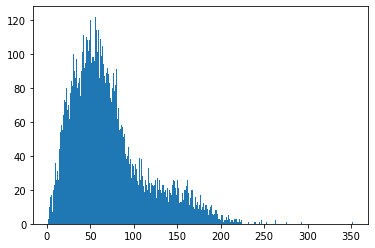

In [19]:
#dataset analysis

#datasets sizes
print(train_df.shape) #8975
print(val_df.shape) #998
print(test_df.shape) #2970

#data balance
print(train_df['label'].value_counts())

tweetLengths = train_df['text'].str.len()
plt.hist(tweetLengths, bins=np.arange(tweetLengths.min(), tweetLengths.max()+1))

plt.show()

#almost all tweets length are under 300 after preprocessing


In [20]:
from sklearn.feature_selection import SelectKBest, chi2 
def tokenization_tweets(X_train, X_val,X_test,features,y_train):

    tokenization = TfidfVectorizer(sublinear_tf=True, max_df=0.70, min_df=5, norm='l2', token_pattern=r'\w{1,}',encoding='latin-1', ngram_range=(1,2), lowercase=True,stop_words='english')

    train = tokenization.fit_transform(X_train)
    val = tokenization.transform(X_val)
    test = tokenization.transform(X_test)
    print(train.shape)
    fs=SelectKBest(chi2, k=features).fit(train, y_train)

    train_transformed =fs.transform(train).toarray()
    val_transformed = fs.transform(val).toarray()
    test_transformed = fs.transform(test).toarray()
    return train_transformed,val_transformed,test_transformed

In [21]:
#vectorize by simple tokenizer
def vectorize(X, max_words):
  tokenizer = Tokenizer(num_words=5000)
  tokenizer.fit_on_texts(X)
  print(len(tokenizer.word_index) + 1)
  X_vectorize = tokenizer.texts_to_sequences(X)
  return X_vectorize

In [22]:
#pad sentences to create same length sentences
def padSequence(X, pad_length):
  return sequence.pad_sequences(X, maxlen=pad_length)

In [23]:
def get_Vocab_Size(df,colName):
  results = Counter()
  df[colName].str.lower().str.split().apply(results.update)
  return len(results)


In [24]:
def train_model(X, Y, model,batchsize, num_epochs, X_val, Y_val, withValidSet = True):
  
  X_batch, Y_batch = X[batchsize:], Y[batchsize:]
  if(withValidSet):
    X_valid_batch, y_valid_batch = X_val[:batchsize], Y_val[:batchsize]
    history = model.fit((X_batch), np.array(Y_batch), validation_data=(np.array(X_valid_batch),np.array(y_valid_batch)), validation_batch_size=batchsize, batch_size=batchsize, epochs=num_epochs)
  else:
    history = model.fit((X_batch), np.array(Y_batch), batch_size=batchsize, epochs=num_epochs)

  return history




In [25]:
def compile_model(model,loss,optimizer,metrics):
  model.compile(loss=loss, 
             optimizer=optimizer, 
             metrics=[metrics])

In [26]:
def plotDiagnostics(history):
  # plot train and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
def evaluate_model(model,X_test,Y_test):
  scores = model.evaluate(X_test, Y_test, verbose=0)

  test_pred=model.predict(X_test,verbose =0)
  y_predicted = np.argmax(test_pred,axis=-1)
  cm = confusion_matrix(y_true = Y_test, y_pred= y_predicted)

  cm_plot_labels = ['non-hate speech','hate speech']
  plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
 
  print('Test accuracy:', scores[1])

In [29]:
#max words in a sentence
max_words = 300

X_test = test_df['text']
X_train = train_df['text']
X_valid = val_df['text']

Y_test = test_df['label']
Y_train = train_df['label']
Y_valid= val_df['label']

#label encode
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)
Y_valid = le.transform(Y_valid)


#vectorize by simple tokenizer

X_train_vec = vectorize(X_train, max_words)
X_test_vec = vectorize(X_test, max_words)
X_valid_vec = vectorize(X_valid, max_words)

#vectorize by tfidf tokenizer
#X_train_vec,X_test_vec,X_valid_vec = tokenization_tweets(X_train,X_test,X_valid,945,Y_train)
#X_train_vec = vectorize_by_Tfidf(X_train, max_words)
#X_test_vec = vectorize_by_Tfidf(X_test, max_words)
#X_valid_vec = vectorize_by_Tfidf(X_valid, max_words)



X_train_vec_pad = padSequence(X_train_vec, max_words)
X_test_vec_pad = padSequence(X_test_vec, max_words)
X_valid_vec_pad = padSequence(X_valid_vec, max_words)


10728
5406
3534


In [30]:
VOCAB_SIZE = get_Vocab_Size(train_df,'text')

In [31]:
#model1 is a stacked model that contains one embedding layer, one simpleRNN layer and one dense layer

embedding_size=10
#max_words = 200

model1=Sequential()
#model1.add(Embedding(VOCAB_SIZE, embedding_size, input_length=945))
model1.add(SimpleRNN(256,input_shape=(1,max_words), activation="relu"))
model1.add(Dense(8, activation="relu")) 
model1.add(Dense(2, activation='sigmoid'))
print(model1.summary())

#Y_text_predictions=model1.predict(X_test)
#print(classification_report(Y_test, Y_text_predictions))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               142592    
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 144,666
Trainable params: 144,666
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
#In model2, we have added two lstm layers apart from embedding layer and dense layer. To reduce overfitting, added dropout and bidirectional flow as well. 

embedding_size=32
#max_words = 200

model2=Sequential()
model2.add(Embedding(VOCAB_SIZE, embedding_size, input_length=max_words))
model2.add(Bidirectional(LSTM(32, dropout=0.5, return_sequences=True)))
model2.add(Bidirectional(LSTM(32, dropout=0.5)))
#model.add(LSTM(32,dropout=0.2))
model2.add(Dense(2, activation='sigmoid'))
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           343264    
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 384,866
Trainable params: 384,866
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/6
279/279 [==============================] - 3s 5ms/step - loss: 4.5467 - accuracy: 0.5453 - val_loss: 0.6701 - val_accuracy: 0.6875
Epoch 2/6
279/279 [==============================] - 1s 4ms/step - loss: 0.6854 - accuracy: 0.5770 - val_loss: 0.6572 - val_accuracy: 0.6875
Epoch 3/6
279/279 [==============================] - 1s 4ms/step - loss: 0.6821 - accuracy: 0.5786 - val_loss: 0.6532 - val_accuracy: 0.6875
Epoch 4/6
279/279 [==============================] - 1s 4ms/step - loss: 0.6796 - accuracy: 0.5786 - val_loss: 0.6517 - val_accuracy: 0.6875
Epoch 5/6
279/279 [==============================] - 1s 4ms/step - loss: 0.6801 - accuracy: 0.5786 - val_loss: 0.6438 - val_accuracy: 0.6875
Epoch 6/6
279/279 [==============================] - 1s 5ms/step - loss: 0.6789 - accuracy: 0.5786 - val_loss: 0.6474 - val_accuracy: 0.6875


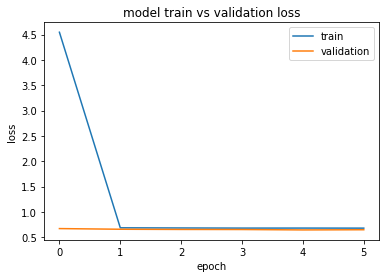

Confusion matrix, without normalization
[[569   0]
 [426   0]]
Test accuracy: 0.5718593001365662


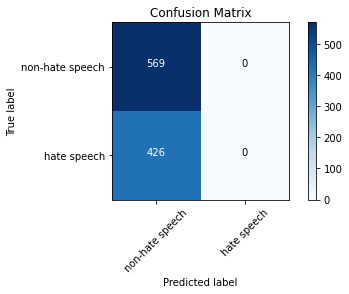

In [33]:

compile_model(model1,'sparse_categorical_crossentropy',keras.optimizers.Adam(),'accuracy')
trainX = np.reshape(X_train_vec_pad, (X_train_vec_pad.shape[0], 1, X_train_vec_pad.shape[1]))
validX = np.reshape(X_valid_vec_pad, (X_valid_vec_pad.shape[0], 1, X_valid_vec_pad.shape[1]))
testX = np.reshape(X_test_vec_pad, (X_test_vec_pad.shape[0], 1, X_test_vec_pad.shape[1]))

history1 = train_model(trainX, Y_train, model1, 32, 6, validX, Y_valid )
plotDiagnostics(history1)
evaluate_model(model1,validX,Y_valid)


Epoch 1/6
279/279 [==============================] - 132s 447ms/step - loss: 0.5913 - accuracy: 0.6755 - val_loss: 0.7131 - val_accuracy: 0.5938
Epoch 2/6
279/279 [==============================] - 123s 440ms/step - loss: 0.4617 - accuracy: 0.7858 - val_loss: 0.8523 - val_accuracy: 0.5000
Epoch 3/6
279/279 [==============================] - 123s 442ms/step - loss: 0.4017 - accuracy: 0.8206 - val_loss: 1.0790 - val_accuracy: 0.5000
Epoch 4/6
279/279 [==============================] - 123s 442ms/step - loss: 0.3605 - accuracy: 0.8433 - val_loss: 1.0759 - val_accuracy: 0.4688
Epoch 5/6
279/279 [==============================] - 123s 439ms/step - loss: 0.3235 - accuracy: 0.8639 - val_loss: 1.1698 - val_accuracy: 0.5625
Epoch 6/6
279/279 [==============================] - 123s 440ms/step - loss: 0.2897 - accuracy: 0.8801 - val_loss: 1.3775 - val_accuracy: 0.5625


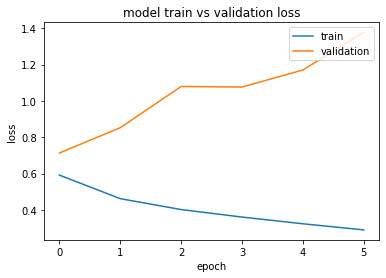

In [34]:
compile_model(model2,'sparse_categorical_crossentropy','adam','accuracy')
history2 = train_model(X_train_vec_pad, Y_train, model2, 32, 6, X_valid_vec_pad, Y_valid )
plotDiagnostics(history2)

#better training accuracy but lower accuracy on testing data, validation acc kept decreasing wit each epoch, training and validation loss fluctuating but validation loss is on the higher side, overfitting

Confusion matrix, without normalization
[[355 214]
 [224 202]]
Test accuracy: 0.5597990155220032


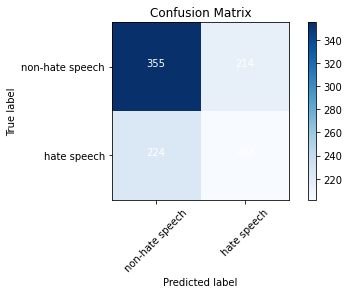

In [35]:
evaluate_model(model2,X_valid_vec_pad,Y_valid)

In [36]:
#third model - DNN

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def train(X_train_mod,X_val_mod,x_test_mod,y_test, y_val, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon):
    model_nn = keras.Sequential()
    model_nn.add(layers.Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(layers.Dropout(drop))
    model_nn.add(layers.Dense(layer2, activation='sigmoid'))
    model_nn.add(layers.Dropout(drop))
    
    model_nn.add(layers.Dense(2, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, 
                                      decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_data=(X_val_mod, y_val),
                 shuffle=shuffle)
    
    test_pred=model_nn.predict(x_test_mod,batch_size=32,verbose =0)
    y_predicted = np.argmax(test_pred,axis=-1)
    cm = confusion_matrix(y_true = y_test, y_pred= y_predicted)

    cm_plot_labels = ['non-hate speech','hate speech']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

    print("Evaluate on test data")
    results = model_nn.evaluate(x_test_mod, y_test,batch_size=32)
    print("test loss, test acc:", results)
    return model_nn

In [37]:
def model3(X_train, y_train,X_val,y_val,X_test,y_test):   
    features = 2500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 20
    lr = 0.00005
    epsilon = None
  
    X_train_mod,X_val_mod,x_test_mod = tokenization_tweets(X_train, X_val,X_test,features,y_train)
    model = train(X_train_mod,X_val_mod, x_test_mod,y_test,y_val,y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon)
    return model

(8943, 3346)
Epoch 1/20
280/280 [==============================] - 5s 15ms/step - loss: 0.7998 - accuracy: 0.5146 - val_loss: 0.6822 - val_accuracy: 0.5786
Epoch 2/20
280/280 [==============================] - 4s 14ms/step - loss: 0.7735 - accuracy: 0.5405 - val_loss: 0.6754 - val_accuracy: 0.5786
Epoch 3/20
280/280 [==============================] - 4s 14ms/step - loss: 0.7576 - accuracy: 0.5441 - val_loss: 0.6681 - val_accuracy: 0.5782
Epoch 4/20
280/280 [==============================] - 4s 14ms/step - loss: 0.7354 - accuracy: 0.5629 - val_loss: 0.6573 - val_accuracy: 0.6440
Epoch 5/20
280/280 [==============================] - 4s 14ms/step - loss: 0.6967 - accuracy: 0.5867 - val_loss: 0.6470 - val_accuracy: 0.6561
Epoch 6/20
280/280 [==============================] - 4s 15ms/step - loss: 0.6420 - accuracy: 0.6483 - val_loss: 0.6660 - val_accuracy: 0.5978
Epoch 7/20
280/280 [==============================] - 4s 14ms/step - loss: 0.5934 - accuracy: 0.6846 - val_loss: 0.6977 - val_acc

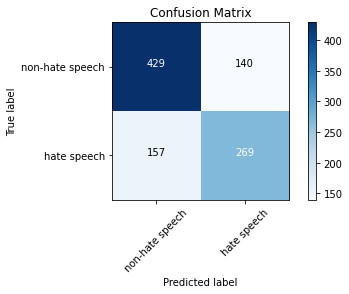

In [38]:
X_train= train_df.drop("label", axis=1) 
y_train = train_df["label"]   
X_val= test_df.drop("label", axis=1) 
y_val = test_df["label"]

X_test= val_df.drop("label", axis=1) 
y_test = val_df["label"]

model = model3(X_train["text"], y_train,X_val["text"],y_val,X_test["text"],y_test)

#training and validation accuracy increased with each epoch while lose decreased, validation loss decreased as well. Better testing accuracy in comparison
#with other two models

In [39]:
#Notes
#RNNs are more suitable when it comes to NLP and LSTM (long short term memory) and lstms are a type of neural network capable of learning order dependence in sequence prediction problems
#we used keras library as it provides easier implementation of the model
#In both the models, training loss is decreasing while validation loss is increasing
#it seems like our both model overfitting on the training data
# we applied dropout, additional layer and bidirectional flow in the second model, and it had some effect on the validation loss but not considerable improvement

#possible reasons for low testing accuracy - not enough training data - more epochs could get some improvement

